# Advanced Sports Analysis with GPT-4V and Supervision

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Dec  8 10:16:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install `ultralytics` and `supervision`

In [3]:
!pip install -q ultralytics supervision gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 10.0 MB/s eta 0:00:00


## Download sample video

In [4]:
!gdown '1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A'

Downloading...
From: https://drive.google.com/uc?id=1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A
To: /content/08fd33_4.mp4
100% 20.3M/20.3M [00:00<00:00, 136MB/s]


In [5]:
VIDEO_PATH = os.path.join(HOME, "08fd33_4.mp4")

## Imports

In [6]:
import cv2
import json
import copy
import base64
import requests

import numpy as np
import supervision as sv

from tqdm.notebook import tqdm
from ultralytics import YOLO
from typing import List, Optional, Dict

## Helper functions

In [7]:
COLOR_HEX_LIST = [
    "#EE4B2B",
    "#FFFF00",
    "#D3D3D3"
]


def annotate_prompt(
    image: np.ndarray,
    detections: sv.Detections,
    labels: Optional[List[str]] = None
) -> np.ndarray:
    """
    Annotates an image with bounding boxes and labels based on provided detections.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in a format compatible with sv.BoundingBoxAnnotator
            and sv.LabelAnnotator, typically a NumPy array.
        detections (sv.Detections): A collection of detections, each typically containing information like
            bounding box coordinates, class IDs, etc., to be used for annotation.
        labels (Optional[List[str]]): A list of strings representing the labels for each detection. If not
            provided, labels are automatically generated as sequential numbers.

    Returns:
        np.ndarray: An annotated version of the input image, with bounding boxes and labels drawn over it.

    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(
        color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS)
    label_annotator = sv.LabelAnnotator(
        color=sv.Color.black(),
        text_color=sv.Color.white(),
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.7)

    if labels is None:
        labels = [str(i) for i in range(len(detections))]

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(
        annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections=detections, labels=labels)

    return annotated_image


def annotate_result(
    image: np.ndarray,
    detections: sv.Detections
) -> np.ndarray:
    """
    Annotates a given image with ellipses around detected objects.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in the format
            acceptable by sv.EllipseAnnotator.
        detections (sv.Detections): An object of sv.Detections, which contains
            the detected objects' information to be annotated on the image.

    Returns:
        np.ndarray: An image (numpy array) with ellipses drawn around the detected
            objects. This image is a modified copy of the input image.
    """
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        color_lookup=sv.ColorLookup.CLASS,
        thickness=4)

    annotated_image = image.copy()
    annotated_image = ellipse_annotator.annotate(
        annotated_image, detections)
    return annotated_image

In [8]:
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"


def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

## Load detection model

In [9]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 169MB/s]


## Extract single frame from sample video

In [10]:
sv.VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=25, total_frames=750)

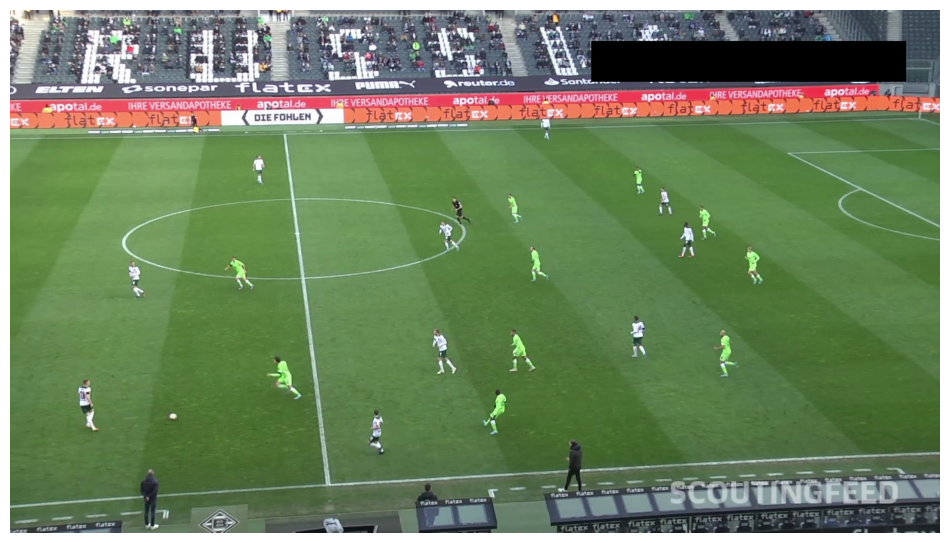

In [11]:
frame_generator = sv.get_video_frames_generator(VIDEO_PATH, start=75)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
sv.plot_image(frame)

## Baseline object detection with YOLO

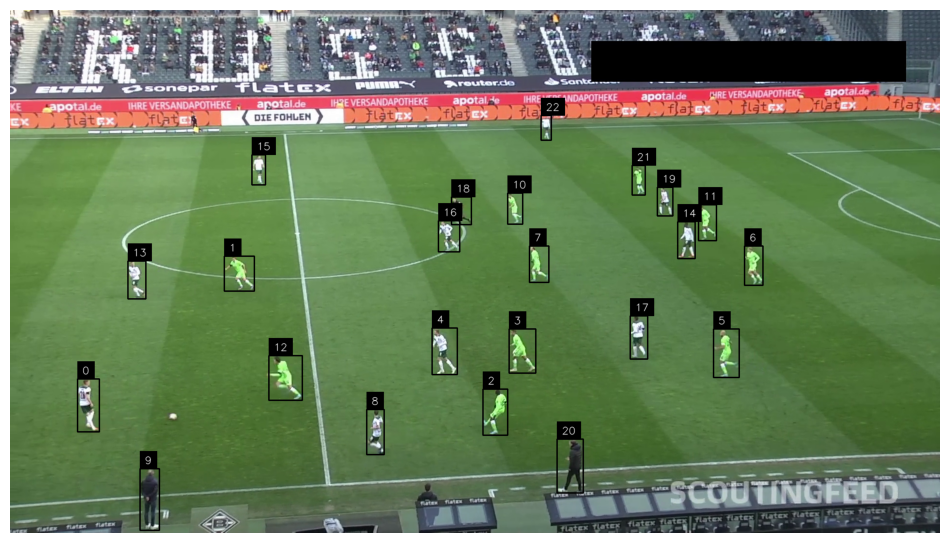

In [12]:
result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.5)[0]

detections = sv.Detections.from_ultralytics(result)

players = detections[detections.class_id == 0]
ball = detections[detections.class_id == 31]

annotated_frame = annotate_prompt(image=frame, detections=players)
sv.plot_image(annotated_frame)

## Prompt GPT-4 Vision

In [13]:
OPENAI_API_KEY = "..."

### Stage 1. Team identification

In [23]:
prompt = (
    "What colors of uniforms are worn by the teams playing in this match? "
    "Return the result in the form of a python list: [<team_uniform_color>, <team_uniform_color>]. "
    "Replace the values in `<>` with the names of the colors."
    "notalk;justgo"
)
response = prompt_image(api_key=OPENAI_API_KEY, images=[frame], prompt=prompt)
print(response)

["white", "neon green"]


In [24]:
CLASSES = json.loads(response) + ["none"]

### Stage 2. Team assignment based on whole photo

In [25]:
prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `white` or `neon green`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include 23 key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ..., 'color_23' are to be replaced with 'white', 'neon green', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "Do not surround the result with backticks (`)"
    "notalk;justgo"
)
annotated_frame = annotate_prompt(image=frame, detections=players)
response = prompt_image(api_key=OPENAI_API_KEY, images=[annotated_frame], prompt=prompt)
print(response)

{
  "0": "white",
  "1": "neon green",
  "2": "neon green",
  "3": "neon green",
  "4": "white",
  "5": "neon green",
  "6": "neon green",
  "7": "neon green",
  "8": "white",
  "9": "none",
  "10": "neon green",
  "11": "neon green",
  "12": "neon green",
  "13": "white",
  "14": "neon green",
  "15": "white",
  "16": "white",
  "17": "white",
  "18": "white",
  "19": "neon green",
  "20": "none",
  "21": "neon green",
  "22": "none"
}


In [26]:
def convert_response_to_array(data: Dict[str, str], count: int, classes: List[str]) -> np.ndarray:
    category_to_id = {category: i for i, category in enumerate(classes)}
    mapped_data = {int(k): category_to_id.get(v) for k, v in data.items() if v in category_to_id}
    return np.array([mapped_data.get(i) for i in range(count)], dtype=object)


def update_class_id(data: Dict[str, str], detections: sv.Detections, classes: List[str]) -> sv.Detections:
    result = copy.deepcopy(detections)
    result.class_id = convert_response_to_array(data=data, count=len(result), classes=classes)
    return result

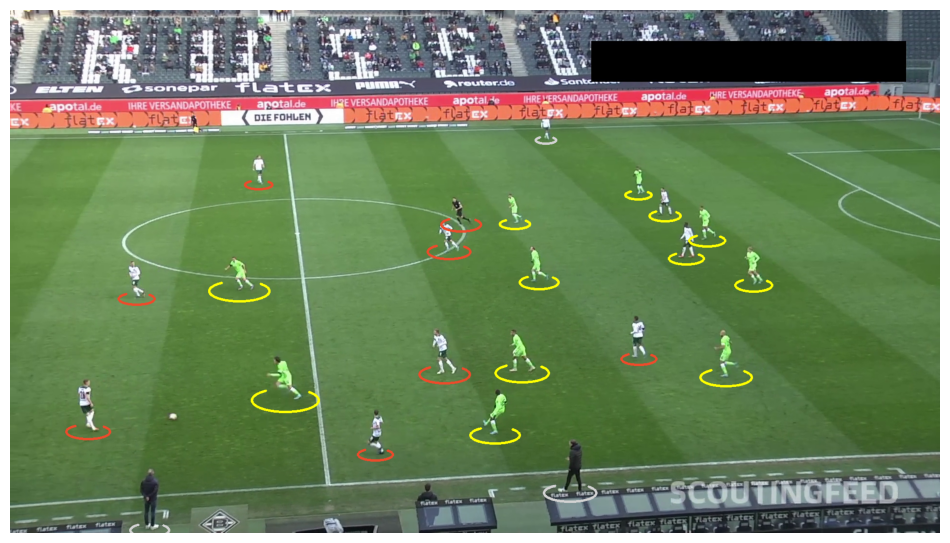

In [27]:
whole_photo_result = update_class_id(data=json.loads(response), detections=players, classes=CLASSES)
result_image = annotate_result(frame, whole_photo_result[whole_photo_result.class_id != None])
sv.plot_image(result_image)

### Stage 3. Team assignment based on crops (one crop per request)

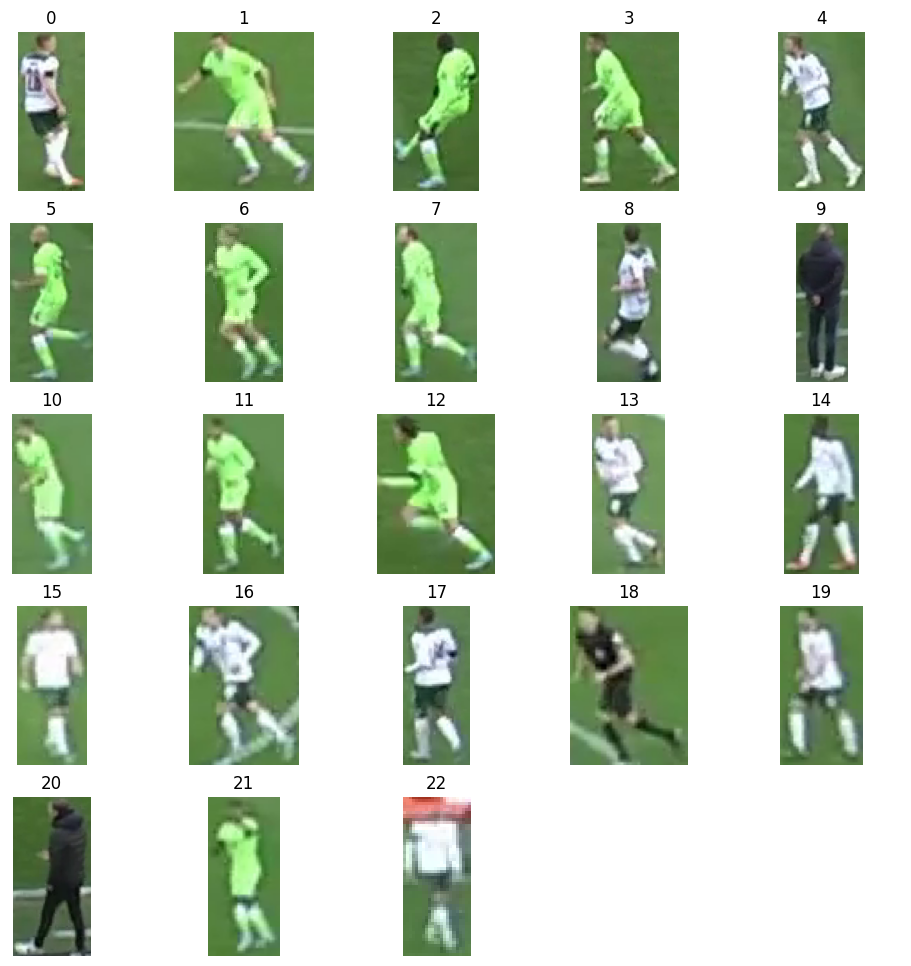

In [28]:
crops = [
    sv.crop_image(frame, players.xyxy[i])
    for i
    in range(len(players))
]

titles = [
    f"{i}"
    for i
    in range(len(players))
]

sv.plot_images_grid(crops, titles=titles, grid_size=(5, 5))

In [29]:
prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `white` or `neon green`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Respond only with `white`, `neon green`, or `none`. "
    "notalk;justgo"
)

response = {}

for i in tqdm(range(len(players))):
    crop = sv.crop_image(frame, players.xyxy[i])
    try:
        player_response = prompt_image(api_key=OPENAI_API_KEY, images=[crop], prompt=prompt)
        response[str(i)] = player_response
    except Exception as final_exception:
        print(i, final_exception)

  0%|          | 0/23 [00:00<?, ?it/s]

In [30]:
response

{'0': 'white',
 '1': 'neon green',
 '2': 'neon green',
 '3': 'neon green',
 '4': 'white',
 '5': 'neon green',
 '6': 'neon green',
 '7': 'neon green',
 '8': 'white',
 '9': 'none',
 '10': 'neon green',
 '11': 'neon green',
 '12': 'neon green',
 '13': 'white',
 '14': 'white',
 '15': 'white',
 '16': 'white',
 '17': 'white',
 '18': 'white',
 '19': 'white',
 '20': 'none',
 '21': 'neon green',
 '22': 'none'}

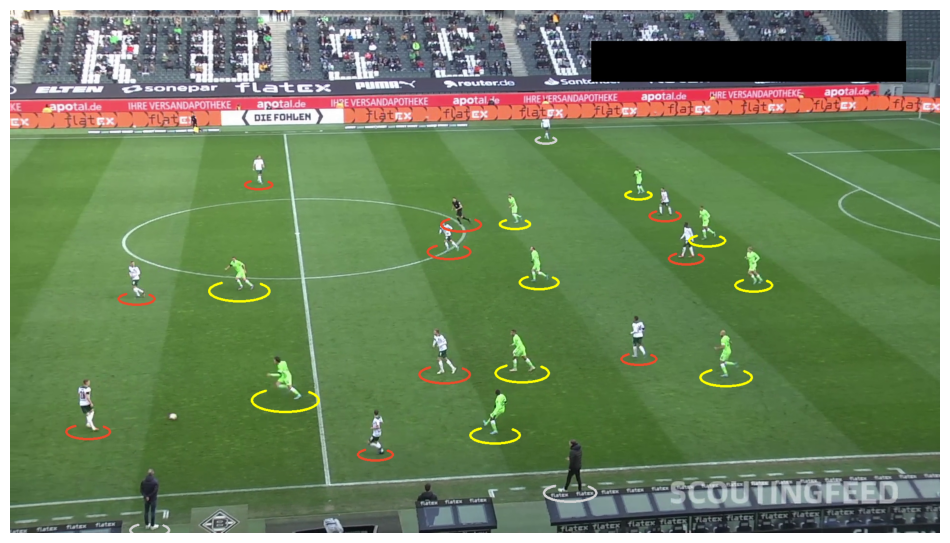

In [31]:
crop_result = update_class_id(data=response, detections=players, classes=CLASSES)
result_image = annotate_result(frame, crop_result[crop_result.class_id != None])
sv.plot_image(result_image)

## Stage 4. Team assignment based on crops (all crops in one request)

In [32]:
xyxy = sv.scale_boxes(players.xyxy, factor=1.2)
crops = [
    sv.crop_image(frame, xyxy[i])
    for i
    in range(len(players))
]

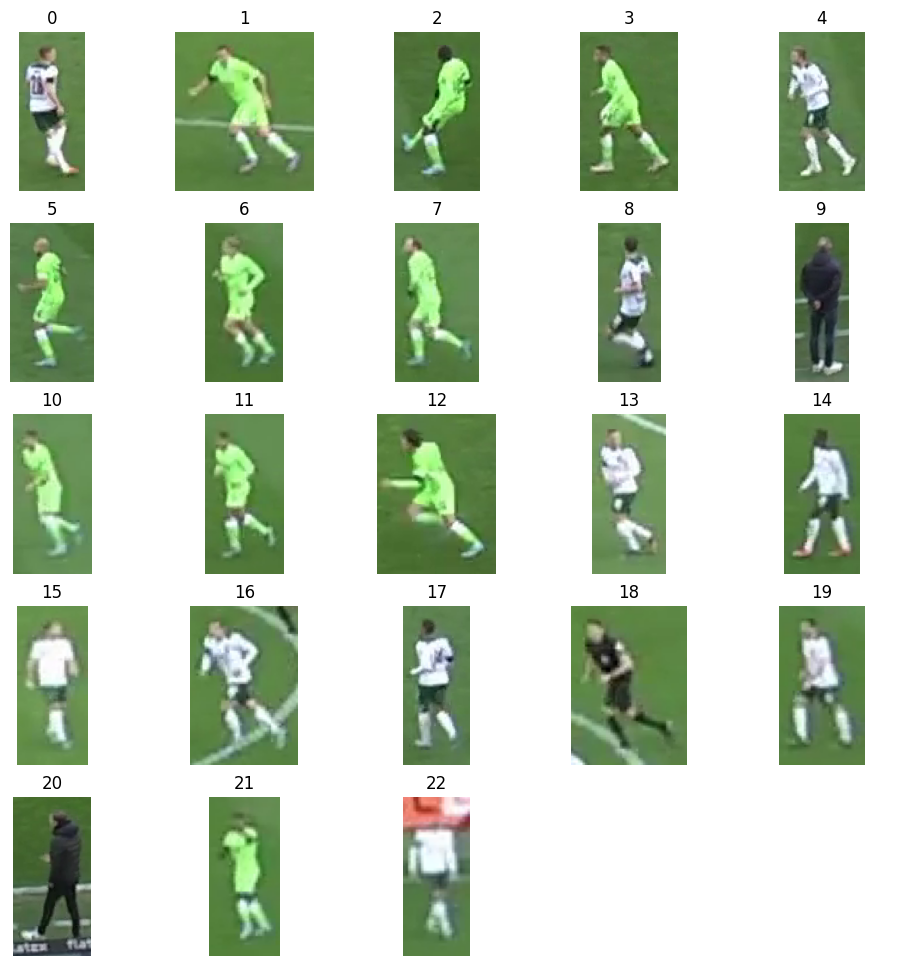

In [33]:
sv.plot_images_grid(crops, titles=titles, grid_size=(5, 5))

In [34]:
prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `white` or `neon green`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include 23 key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ..., 'color_23' are to be replaced with 'white', 'neon green', or 'none', as applicable. "
    "Do not surround the result with backticks (`)"
    "notalk;justgo"
)

response = prompt_image(api_key=OPENAI_API_KEY, images=crops, prompt=prompt)
print(response)

{
  "0": "white",
  "1": "neon green",
  "2": "neon green",
  "3": "neon green",
  "4": "white",
  "5": "neon green",
  "6": "neon green",
  "7": "neon green",
  "8": "white",
  "9": "none",
  "10": "neon green",
  "11": "neon green",
  "12": "neon green",
  "13": "white",
  "14": "white",
  "15": "white",
  "16": "white",
  "17": "white",
  "18": "white",
  "19": "none",
  "20": "neon green",
  "21": "none",
  "22": "white"
}


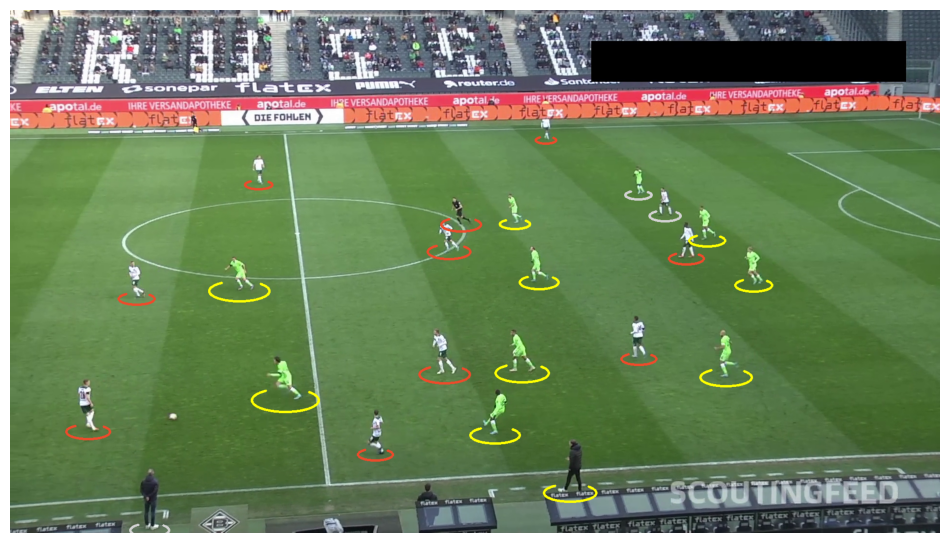

In [35]:
batch_crop_result = update_class_id(data=json.loads(response), detections=players, classes=CLASSES)
result_image = annotate_result(frame, batch_crop_result[batch_crop_result.class_id != None])
sv.plot_image(result_image)

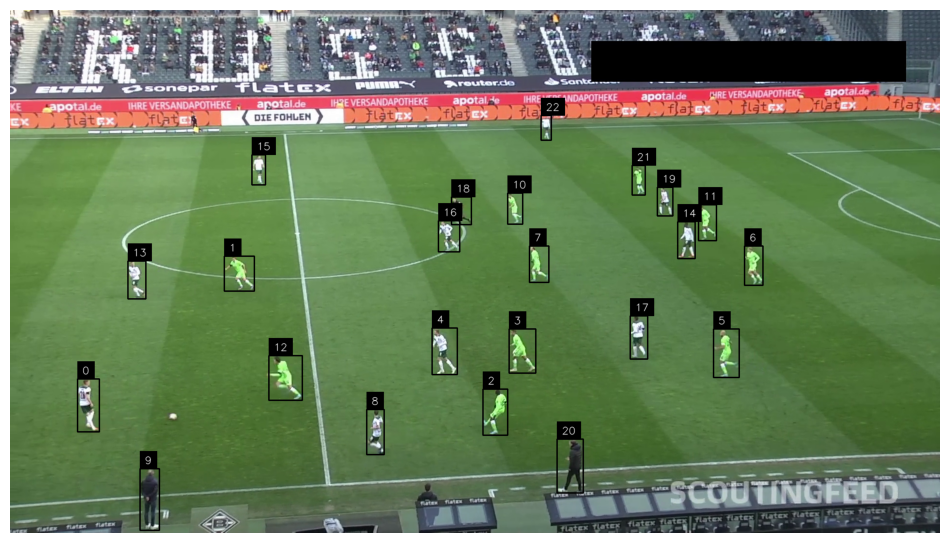

In [36]:
sv.plot_image(annotated_frame)

**MOTE:** Images near the end of the crops list, are incorrectly qualified.

## Stage 5. Team assignment based on crops (small batches)

In [42]:
import math

def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

xyxy = sv.scale_boxes(players.xyxy, factor=1.2)

crops = [
    sv.crop_image(frame, xyxy[i])
    for i in range(len(players))
]

prompt = (
    "Identify the team affiliation of the marked individual in the image: "
    "Options are `white` or `neon green`. If the marked individual does not belong to either team "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ... are to be replaced with 'white', 'neon green', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "Do not surround the result with backticks (`)"
    "notalk;justgo"
)

batch_size = 10
crop_batches = list(chunk_list(crops, batch_size))
merged_response = {}

for i, batch in enumerate(crop_batches):
    start_index = i * batch_size
    response = prompt_image(api_key=OPENAI_API_KEY, images=batch, prompt=prompt)
    response=json.loads(response)

    for key, value in response.items():
        merged_response[str(int(key) + start_index)] = value

print(merged_response)

{'0': 'white', '1': 'neon green', '2': 'neon green', '3': 'neon green', '4': 'white', '5': 'neon green', '6': 'neon green', '7': 'neon green', '8': 'white', '9': 'none', '10': 'neon green', '11': 'neon green', '12': 'neon green', '13': 'white', '14': 'white', '15': 'white', '16': 'white', '17': 'white', '18': 'none', '19': 'white', '20': 'none', '21': 'neon green', '22': 'white'}


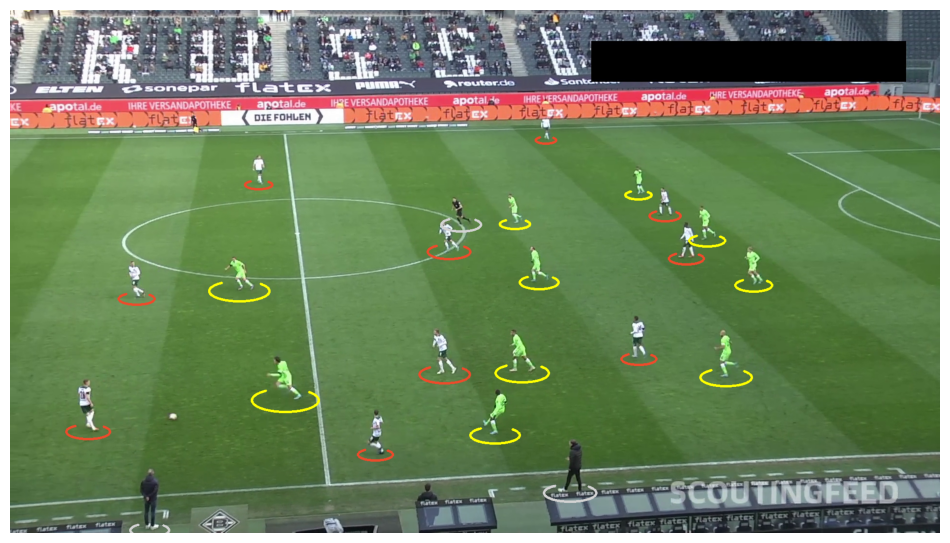

In [48]:
small_batch_crop_result = update_class_id(data=merged_response, detections=players, classes=CLASSES)
result_image = annotate_result(frame, small_batch_crop_result[small_batch_crop_result.class_id != None])
sv.plot_image(result_image)